In [1]:
import json

from itertools import islice

import numpy as np
import pandas as pd
import umap
import umap.plot

from pytility import arg_to_iter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Some plotting libraries
import matplotlib.pyplot as plt
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE

%matplotlib inline
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
def process(lines, required_features, copy_features):
    required_features = frozenset(arg_to_iter(required_features))
    copy_features = tuple(arg_to_iter(copy_features))

    for line in arg_to_iter(lines):
        item = json.loads(line)
        if all(item.get(feature) is not None for feature in required_features):
            yield {
                feature: item.get(feature) for feature in copy_features
            } if copy_features else item


def load(path, required_features=None, copy_features=None, max_items=None):
    with open(path) as file:
        items = process(
            lines=file, required_features=required_features, copy_features=copy_features
        )
        items = islice(items, max_items) if max_items else items
        yield from items

<IPython.core.display.Javascript object>

In [4]:
records = load(path="../../board-game-data/scraped/bgg_GameItem.jl")
games = pd.DataFrame.from_records(records, index="bgg_id")
games.head()

,alt_name,artist,avg_rating,bayes_rating,best_rating,category,compilation,complexity,cooperative,description,...,rank,stddev_rating,url,video_url,worst_rating,year,implementation,expansion,integration,compilation_of
bgg_id,,,,,,,,,,,,,,,,,,,,,
1,"[Die Macher, 德国大选, 디 마허]","[Marcus Gschwendtner:12517, Harald Lieske:4959]",7.62301,7.15698,10,"[Economic:1021, Negotiation:1026, Political:1001]",False,4.3441,False,Die Macher is a game about seven sequential po...,...,252.0,1.59774,https://boardgamegeek.com/boardgame/1,"[http://www.youtube.com/watch?v=2dBbY-bKVoE, h...",1,1986.0,NaN,NaN,NaN,NaN
2,[Dragonmaster],[Bob Pepper:12424],6.61418,5.80881,10,"[Card Game:1002, Fantasy:1010]",False,1.9630,False,Dragonmaster is a trick-taking card game based...,...,3432.0,1.44775,https://boardgamegeek.com/boardgame/2,"[http://www.youtube.com/watch?v=sKXnys4wxt8, h...",1,1981.0,[2174],NaN,NaN,NaN
3,"[Samurai, Samouraï, Samurái, Samuraj, Самурай,...",[Franz Vohwinkel:11883],7.44228,7.24748,10,"[Abstract Strategy:1009, Medieval:1035]",False,2.4961,False,"Part of the Knizia tile-laying trilogy, Samura...",...,195.0,1.18415,https://boardgamegeek.com/boardgame/3,"[http://www.youtube.com/watch?v=yqO-mYfzIdg, h...",1,1998.0,NaN,NaN,NaN,NaN
4,[Tal der Könige],[Thomas di Paolo:2277],6.60612,5.70425,10,[Ancient:1050],False,2.6667,False,When you see the triangular box and the luxuri...,...,4489.0,1.22370,https://boardgamegeek.com/boardgame/4,NaN,1,1992.0,NaN,NaN,NaN,NaN
5,"[Acquire, Cartel, Grand Hôtel, Hotel-Haie, Hot...","[Scott Okumura:12658, Peter Whitley:18317]",7.34589,7.16978,10,[Economic:1021],False,2.5063,False,"In Acquire, each player strategically invests ...",...,245.0,1.33793,https://boardgamegeek.com/boardgame/5,"[http://www.youtube.com/watch?v=dxwp5GqekJU, h...",1,1964.0,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [5]:
REQUIRED_FEATURES = {"bgg_id", "bgg_user_name", "bgg_user_rating"}
COPY_FEATURES = REQUIRED_FEATURES | {"bgg_user_owned", "bgg_user_play_count"}

records = load(
    path="../../board-game-data/scraped/bgg_RatingItem.jl",
    required_features=REQUIRED_FEATURES,
    copy_features=COPY_FEATURES,
)
%time ratings = pd.DataFrame.from_records(records)
ratings.head()

CPU times: user 4min 48s, sys: 21.6 s, total: 5min 9s
Wall time: 5min 19s


,bgg_id,bgg_user_name,bgg_user_play_count,bgg_user_owned,bgg_user_rating
0,13,beastvol,0,True,8.0
1,118,beastvol,0,True,7.0
2,278,beastvol,0,True,7.0
3,823,beastvol,0,True,6.0
4,3076,beastvol,0,True,9.0


<IPython.core.display.Javascript object>

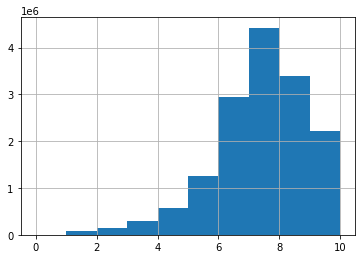

<IPython.core.display.Javascript object>

In [6]:
ratings.bgg_user_rating.hist(bins=10)

In [7]:
good_ratings = ratings[ratings.bgg_user_rating >= 9]
good_ratings.shape

(2216866, 5)

<IPython.core.display.Javascript object>

In [8]:
ratings_by_games = good_ratings.groupby("bgg_id").agg(
    {"bgg_user_rating": "mean", "bgg_user_name": (";".join, len),}
)
ratings_by_games.columns = (
    # "bgg_id",
    "bgg_user_rating",
    "bgg_user_name_list",
    "bgg_user_name_num",
)
ratings_by_games.head()

,bgg_user_rating,bgg_user_name_list,bgg_user_name_num
bgg_id,,,
1,9.351416,.jck.;0492372665;0hohj;13steps;13walker;4x sca...,1278
2,9.374468,ahtitan;bard;bigscotty;bradyls;bvesco;calicoda...,47
3,9.250498,-toni-;-xxx-;1no_momo;47029;57881;8inferno8;a_...,1868
4,9.111111,arthemix;bernard;chuft;dix de sabre;gamegrunt;...,18
5,9.344686,1979 amc treo 755p;1no_momo;216stitches;2ndpla...,2560


<IPython.core.display.Javascript object>

In [9]:
game_data = ratings_by_games.join(games, how="inner")
game_data.head()

,bgg_user_rating,bgg_user_name_list,bgg_user_name_num,alt_name,artist,avg_rating,bayes_rating,best_rating,category,compilation,...,rank,stddev_rating,url,video_url,worst_rating,year,implementation,expansion,integration,compilation_of
bgg_id,,,,,,,,,,,,,,,,,,,,,
1,9.351416,.jck.;0492372665;0hohj;13steps;13walker;4x sca...,1278,"[Die Macher, 德国大选, 디 마허]","[Marcus Gschwendtner:12517, Harald Lieske:4959]",7.62301,7.15698,10,"[Economic:1021, Negotiation:1026, Political:1001]",False,...,252.0,1.59774,https://boardgamegeek.com/boardgame/1,"[http://www.youtube.com/watch?v=2dBbY-bKVoE, h...",1,1986.0,NaN,NaN,NaN,NaN
2,9.374468,ahtitan;bard;bigscotty;bradyls;bvesco;calicoda...,47,[Dragonmaster],[Bob Pepper:12424],6.61418,5.80881,10,"[Card Game:1002, Fantasy:1010]",False,...,3432.0,1.44775,https://boardgamegeek.com/boardgame/2,"[http://www.youtube.com/watch?v=sKXnys4wxt8, h...",1,1981.0,[2174],NaN,NaN,NaN
3,9.250498,-toni-;-xxx-;1no_momo;47029;57881;8inferno8;a_...,1868,"[Samurai, Samouraï, Samurái, Samuraj, Самурай,...",[Franz Vohwinkel:11883],7.44228,7.24748,10,"[Abstract Strategy:1009, Medieval:1035]",False,...,195.0,1.18415,https://boardgamegeek.com/boardgame/3,"[http://www.youtube.com/watch?v=yqO-mYfzIdg, h...",1,1998.0,NaN,NaN,NaN,NaN
4,9.111111,arthemix;bernard;chuft;dix de sabre;gamegrunt;...,18,[Tal der Könige],[Thomas di Paolo:2277],6.60612,5.70425,10,[Ancient:1050],False,...,4489.0,1.22370,https://boardgamegeek.com/boardgame/4,NaN,1,1992.0,NaN,NaN,NaN,NaN
5,9.344686,1979 amc treo 755p;1no_momo;216stitches;2ndpla...,2560,"[Acquire, Cartel, Grand Hôtel, Hotel-Haie, Hot...","[Scott Okumura:12658, Peter Whitley:18317]",7.34589,7.16978,10,[Economic:1021],False,...,245.0,1.33793,https://boardgamegeek.com/boardgame/5,"[http://www.youtube.com/watch?v=dxwp5GqekJU, h...",1,1964.0,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [10]:
popular_games = game_data[game_data["rank"] <= 1000]
popular_games.shape

(1001, 46)

<IPython.core.display.Javascript object>

In [11]:
vectorizer = CountVectorizer(binary=True, min_df=30, token_pattern=r"[^;]+")
games_by_users = vectorizer.fit_transform(popular_games.bgg_user_name_list)
games_by_users.shape

(1001, 7674)

<IPython.core.display.Javascript object>

In [12]:
games_by_users_model = umap.UMAP(
    n_neighbors=20, n_components=2, metric="jaccard", unique=True
)
games_by_users_model.fit(games_by_users.todense())

/Users/markus/.local/share/virtualenvs/recommend-games-server-4vo11Vep/lib/python3.7/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


UMAP(a=None, angular_rp_forest=True, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='jaccard',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=True, verbose=False)

<IPython.core.display.Javascript object>

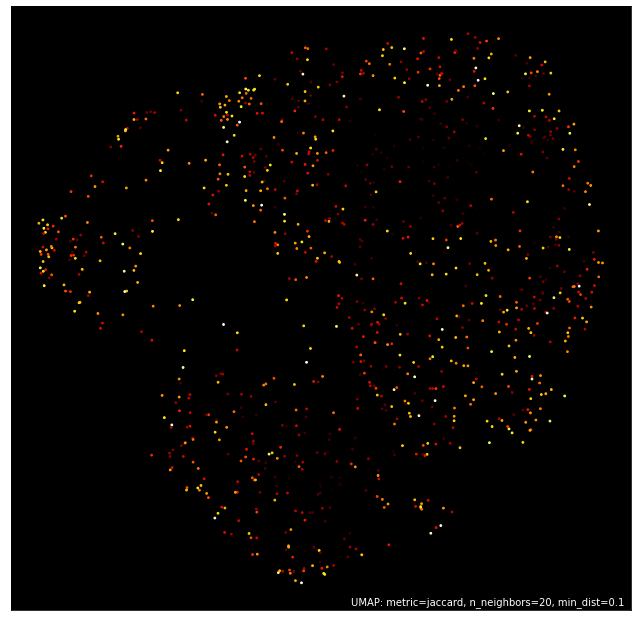

<IPython.core.display.Javascript object>

In [13]:
umap.plot.points(games_by_users_model, values=popular_games["rank"], theme="fire")

In [15]:
hover_data = popular_games[["name", "rank", "bayes_rating"]]
game_plot = umap.plot.interactive(
    games_by_users_model,
    values=hover_data["rank"],
    hover_data=hover_data,
    theme="fire",
    point_size=5,
)
show(game_plot)

<IPython.core.display.Javascript object>

In [14]:
popular_games.shape

(5950, 47)

<IPython.core.display.Javascript object>

In [15]:
games_by_users_model.graph_.shape

(5950, 5950)

<IPython.core.display.Javascript object>